This notebook will first do simple Exploratory Data Analysis (EDA) of the dataset. And then train the model for sign classification.

The data analysis and visualization/animation is based on notebooks here: 
  * https://www.kaggle.com/code/danielpeshkov/animated-data-visualization
  * https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline
  * https://www.kaggle.com/code/ted0071/gislr-visualization

This notebook's model is based on this one: https://www.kaggle.com/code/markwijkhuizen/gislr-tf-data-processing-transformer-training with edits:
 * Learn data preprocessing
 * Reproduce the results
 * twist the models and/or features
 
 LSTM baseline with original notebook


0.6545733

Public Score
0.5624196

In [ ]:
# !pip list | grep -i proto

In [1]:
!pip install uv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 87.6 MB/s eta 0:00:00:00:0100:01


In [2]:
# !pip install -q flatbuffers 2> /dev/null
# !pip install -q mediapipe 2> /dev/null
# #tensorflow                             2.11.0
# tensorflow-addons                      0.19.0
!uv pip install tensorflow==2.11.0 tensorflow_addons --system
!uv pip install flatbuffers mediapipe tflite-runtime --system
!uv pip install protobuf==3.20.3 --system

Using Python 3.10.12 environment at: /usr
Resolved 54 packages in 392ms                                        
⠙ Preparing packages... (0/11)                                                  
⠙ Preparing packages... (0/11)---     0 B/9.59 KiB                      
gast       ------------------------------     0 B/9.59 KiB
⠙ Preparing packages... (0/11)-------------     0 B/17.88 KiB           
gast       ------------------------------     0 B/9.59 KiB
typeguard  ------------------------------     0 B/17.19 KiB
⠙ Preparing packages... (0/11)-------------     0 B/17.88 KiB           
gast       ------------------------------     0 B/9.59 KiB
typeguard  ------------------------------     0 B/17.19 KiB
⠙ Preparing packages... (0/11)--------- 14.82 KiB/17.88 KiB         
gast       ------------------------------     0 B/9.59 KiB
typeguard  ------------------------------ 14.83 KiB/17.19 KiB
⠙ Preparing packages... (0/11)--------- 14.82 KiB/17.88 KiB         
gast       ---------------------

In [3]:
## Animation Libraries Used
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Data analysis libraries used



## Model training libraies

import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

import os
import json
import glob
import sys

import math
import gc
import sys
import sklearn
import scipy


import cv2
import matplotlib.pyplot as plt
from matplotlib import animation
from pathlib import Path
import IPython
from IPython.display import display
from IPython.display import HTML

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2


print(f'Tensorflow V{tf.__version__}')
print(f'Keras V{tf.keras.__version__}')
print(f'Python V{sys.version}')

print(f' V{sys.version}')


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

Tensorflow V2.11.0
Keras V2.11.0
Python V3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
 V3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


# Part 1: Load Data and Simple Statistics and Visulization

In [4]:
import os, json
DATA_DIR = "/kaggle/input/asl-signs"
# LANDMARK_FILES_DIR = os.path.join(DATA_DIR, "train_landmark_files")
TRAIN_FILE = os.path.join(DATA_DIR, "train.csv")
LABEL_MAP = json.load(open(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json"), "r"))

print(TRAIN_FILE)
# print(LABEL_MAP)

/kaggle/input/asl-signs/train.csv


## 1.1 Training set

In [5]:
# how many training example (videos of signs)
train_df = pd.read_csv(TRAIN_FILE)
print(train_df.info())
display(train_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB
None


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [6]:
# Sign (label) statistics  - how many labels in the training set
print(train_df["sign"].describe().to_frame().T)
sign_count_map = train_df["sign"].value_counts().to_dict()
print("\t1. Number Of Unique Signs                  -->", len(sign_count_map))
print("\t2. Average Number of Rows Per Sign         -->", np.array(list(sign_count_map.values())).mean())
print("\t3. Standard Deviation in Counts Per Sign   -->", np.array(list(sign_count_map.values())).std())
print("\t4. Minimum Number of Examples For One Sign -->", np.array(list(sign_count_map.values())).min())
print("\t5. Maximum Number of Examples For One Sign -->", np.array(list(sign_count_map.values())).max())

# print("\n\n... SIGN COLUMN HISTOGRAM:\n")
# fig = px.histogram(train_df, y=train_df["sign"], color="sign", orientation="h", height=5000,
#     labels={"y":"<b>Sign (label)</b>", "count":"<b>Total Row Count</b>"}, title="<b>Row Counts by Sign (label)</b>",
#     category_orders={"sign": train_df["sign"].value_counts().index}
# )
# fig.update_yaxes(title_text="<b>Total Row Count</b>")
# fig.update_layout(showlegend=False)
# fig.show()

      count unique     top freq
sign  94477    250  listen  415
	1. Number Of Unique Signs                  --> 250
	2. Average Number of Rows Per Sign         --> 377.908
	3. Standard Deviation in Counts Per Sign   --> 19.356537293638034
	4. Minimum Number of Examples For One Sign --> 299
	5. Maximum Number of Examples For One Sign --> 415


In [7]:
# training example from how many participants

print("\n... BASICS OF THE PARTICIPANT ID COLUMN:\n")
print(train_df["participant_id"].astype(str).describe().to_frame().T)

participant_count_map = train_df["participant_id"].value_counts().to_dict()
print("\t1. Number of Unique Participants                  -->", len(participant_count_map))
print("\t2. Average Number of Rows Per Participant         -->", np.array(list(participant_count_map.values())).mean())
print("\t3. Standard Deviation in Counts Per Participant   -->", np.array(list(participant_count_map.values())).std())
print("\t4. Minimum Number of Examples For One Participant -->", np.array(list(participant_count_map.values())).min())
print("\t5. Maximum Number of Examples For One Participant -->", np.array(list(participant_count_map.values())).max())

# print("\n\n... PARTICIPANT ID COLUMN HISTOGRAM:\n")
# fig = px.histogram(
#     train_df, x=train_df["participant_id"].astype(str), color="participant_id",
#     labels={"x":"<b>Participant ID</b>", "count":"<b>Total Row Count</b>"}, title="<b>Row Counts by Participant ID</b>",
#     category_orders={"participant_id": train_df["participant_id"].value_counts().index}
# )
# fig.update_yaxes(title_text="<b>Total Row Count</b>")
# fig.update_layout(showlegend=False)
# fig.show()

# print("\n... GOING FORWARD WE SET THIS COLUMN TO BE A STRING")
# train_df["participant_id"] = train_df["participant_id"].astype(str)
# subsample_train_df["participant_id"] = subsample_train_df["participant_id"].astype(str)


... BASICS OF THE PARTICIPANT ID COLUMN:

                count unique    top  freq
participant_id  94477     21  49445  4968
	1. Number of Unique Participants                  --> 21
	2. Average Number of Rows Per Participant         --> 4498.9047619047615
	3. Standard Deviation in Counts Per Participant   --> 490.7731417304649
	4. Minimum Number of Examples For One Participant --> 3338
	5. Maximum Number of Examples For One Participant --> 4968


## 1.2 Sample Video (sequence of frames) - visulize landmarks of the sequence of frames

In [8]:
# first sign video frame file as sample to see the frame data 
# it has face, left
sample_sign_file_name = train_df.iloc[0]['path']
sample_sign_df = pd.read_parquet(os.path.join(DATA_DIR, sample_sign_file_name))
print("sign frames for sign ", train_df.iloc[0]['sign'] )
print(sample_sign_df)

sign frames for sign  blow
       frame            row_id        type  landmark_index         x  \
0         20         20-face-0        face               0  0.494400   
1         20         20-face-1        face               1  0.496017   
2         20         20-face-2        face               2  0.500818   
3         20         20-face-3        face               3  0.489788   
4         20         20-face-4        face               4  0.495304   
...      ...               ...         ...             ...       ...   
12484     42  42-right_hand-16  right_hand              16  0.001660   
12485     42  42-right_hand-17  right_hand              17  0.042694   
12486     42  42-right_hand-18  right_hand              18  0.006723   
12487     42  42-right_hand-19  right_hand              19 -0.014755   
12488     42  42-right_hand-20  right_hand              20 -0.031811   

              y         z  
0      0.380470 -0.030626  
1      0.350735 -0.057565  
2      0.359343 -0.03028

In [9]:
print(sample_sign_df['frame'].nunique()) # number of frames in this video of "blow" sign
sample_sign_df[sample_sign_df['frame'] == 20]['type'].value_counts()

23


type
face          468
pose           33
left_hand      21
right_hand     21
Name: count, dtype: int64

## Hand Landmarks
​
<center>
<div>
    <img src="https://developers.google.com/static/mediapipe/images/solutions/hand-landmarks.png" width="600">
</div>
</center>
​
[Source](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker#get_started)



## Pose Landmarks

<center>
<div>
    <img src="https://mediapipe.dev/images/mobile/pose_tracking_full_body_landmarks.png" width="600">
</div>
</center>

[Source](https://google.github.io/mediapipe/solutions/pose.html#pose-landmark-model-blazepose-ghum-3d)

In [10]:
# choose features - landmarks to use for classification
# Google mediapipe landmarks index: 468 face landmarks, 21 landmarks for each hand, and 
# https://developers.google.com/mediapipe/solutions/vision/pose_landmarker#:~:text=The%20MediaPipe%20Pose%20Landmarker%20task,with%20single%20images%20or%20video.
# The pose consists of a total of 33 landmark points with indices from 0 to 32. 
# pose : 0-10 are assigned to the face, 11-22 to the upper body, and 23-32 to the lower body.

# https://medium.com/@hotakoma/mediapipe-landmark-face-hand-pose-sequence-number-list-view-778364d6c414
# here in the sign video, each frame has 543 landmards:     
#    face: 0:468
#     left_hand: 468:489
#     pose: 489:522
#     right_hand: 522:544

# More resource: https://www.youtube.com/watch?v=hV5S4iQhNkI

# sample_sign_df[sample_sign_df['type'] == "face"].landmark_index
sample_sign_df[(sample_sign_df['frame'] == 20) & (sample_sign_df['type'] == 'pose')].landmark_index
# sample_sign_df[(sample_sign_df['frame'] == 20) & (sample_sign_df['type'] == 'left_hand')].landmark_index
# sample_sign_df[(sample_sign_df['frame'] == 20) & (sample_sign_df['type'] == 'right_hand')].landmark_index


489     0
490     1
491     2
492     3
493     4
494     5
495     6
496     7
497     8
498     9
499    10
500    11
501    12
502    13
503    14
504    15
505    16
506    17
507    18
508    19
509    20
510    21
511    22
512    23
513    24
514    25
515    26
516    27
517    28
518    29
519    30
520    31
521    32
Name: landmark_index, dtype: int16

In [11]:
thank_you_sign_file = train_df[train_df["sign"] == "thankyou"].iloc[1].path
path_to_sign = thank_you_sign_file
sign = pd.read_parquet(os.path.join(DATA_DIR, path_to_sign))
sign.y = sign.y * -1

In [12]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x], 
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x], 
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x], 
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y], 
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y], 
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y], 
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]] 
    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x], 
         [pose.iloc[10].x, pose.iloc[9].x], 
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x, 
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x], 
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x], 
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x], 
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y], 
         [pose.iloc[10].y, pose.iloc[9].y], 
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y, 
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y], 
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y], 
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y], 
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y



The sign being shown here is: thankyou


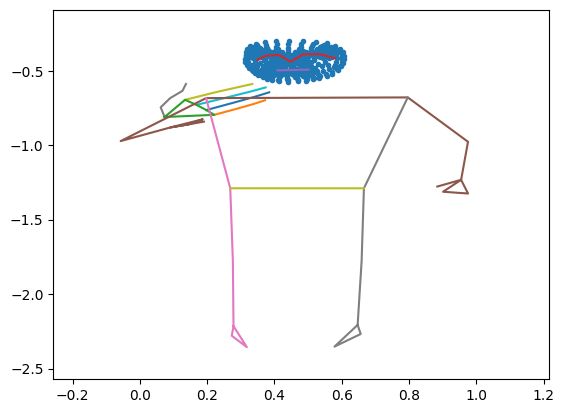

In [13]:
def animation_frame(f):
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
        
print(f"The sign being shown here is: {train_df[train_df.path==f'{path_to_sign}'].sign.values[0]}")

## These values set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])
fun_animation = FuncAnimation(fig, func=animation_frame, frames=sign.frame.unique())

HTML(fun_animation.to_html5_video())

In [14]:
# 3D visualization 
# https://www.kaggle.com/code/ted0071/gislr-visualization


In [15]:


mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

In [16]:
class Cfg:
    RANDOM_STATE = 2023
    INPUT_ROOT = Path('/kaggle/input/asl-signs/')
    OUTPUT_ROOT = Path('kaggle/working')
    INDEX_MAP_FILE = INPUT_ROOT / 'sign_to_prediction_index_map.json'
    TRAN_FILE = INPUT_ROOT / 'train.csv'
    INDEX = 'sequence_id'
    ROW_ID = 'row_id'

In [17]:
print(f'cv2 version: {cv2.__version__}')
print(f'MediaPipe version: {mp.__version__}')
print(f'IPython version: {IPython.__version__}')


cv2 version: 4.10.0
MediaPipe version: 0.10.21
IPython version: 7.34.0


In [18]:
def read_index_map(file_path=Cfg.INDEX_MAP_FILE):
    """Reads the sign to predict as json file."""
    with open(file_path, "r") as f:
        result = json.load(f)
    return result    

def read_train(file_path=Cfg.TRAN_FILE):
    """Reads the train csv as pandas data frame."""
    return pd.read_csv(file_path).set_index(Cfg.INDEX)

def read_landmark_data_by_path(file_path, input_root=Cfg.INPUT_ROOT):
    """Reads landmak data by the given file path."""
    data = pd.read_parquet(input_root / file_path)
    return data.set_index(Cfg.ROW_ID)

def read_landmark_data_by_id(sequence_id, train_data):
    """Reads the landmark data by the given sequence id."""
    file_path = train_data.loc[sequence_id]['path']
    return read_landmark_data_by_path(file_path)



mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh
mp_pose = mp.solutions.pose

def get_random_sequence_id(train_data):
    idx = np.random.randint(0, len(train_data))
    return train_data.index[idx]

# def create_blank_image(height, width):
#     return np.zeros((height, width, 3), np.uint8)

def create_blank_image(height, width):
    return np.ones((height, width, 3), np.uint8)

def draw_landmarks(
    data, 
    image, 
    frame_id, 
    landmark_type, 
    connection_type, 
    landmark_color=(255, 0, 0), 
    connection_color=(0, 20, 255), 
    thickness=1, 
    circle_radius=1
):
    """Draws landmarks"""
    df = data.groupby(['frame', 'type']).get_group((frame_id, landmark_type))
    landmarks = [landmark_pb2.NormalizedLandmark(x=lm.x, y=lm.y, z=lm.z) for idx, lm in df.iterrows()]
    landmark_list = landmark_pb2.NormalizedLandmarkList(landmark = landmarks)

    mp_drawing.draw_landmarks(
        image=image,
        landmark_list=landmark_list, 
        connections=connection_type,
        landmark_drawing_spec=mp_drawing.DrawingSpec(
            color=landmark_color, 
            thickness=thickness, 
            circle_radius=circle_radius),
        connection_drawing_spec=mp_drawing.DrawingSpec(
            color=connection_color, 
            thickness=thickness, 
            circle_radius=circle_radius))
    return image

def draw_left_hand(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='left_hand', 
        connection_type=mp_hands.HAND_CONNECTIONS,
        landmark_color=(255, 0, 0),
#         connection_color=(0, 20, 255),
        connection_color=(0, 255, 0),
        thickness=3, 
        circle_radius=3)

def draw_right_hand(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='right_hand', 
        connection_type=mp_hands.HAND_CONNECTIONS,
        landmark_color=(255, 0, 0),
#         connection_color=(0, 20, 255),
        connection_color=(0, 255, 0),
        thickness=3, 
        circle_radius=3)

def draw_face(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='face', 
        connection_type=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_color=(255, 255, 255),
        connection_color=(0, 255, 0))      
    
def draw_pose(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='pose', 
        connection_type=mp_pose.POSE_CONNECTIONS,
#         landmark_color=(255, 255, 255),
#         connection_color=(255, 0, 0),
        landmark_color=(255, 0, 0),
        connection_color=(0, 255, 0),
        thickness=2, 
        circle_radius=2)

def create_frame(data, frame_id, height=1000, width=1000):
    image = create_blank_image(height, width)    

    draw_pose(data, image, frame_id) 
    draw_left_hand(data, image, frame_id)    
    draw_right_hand(data, image, frame_id)  
    draw_face(data, image, frame_id)
     
    return image

<ipython-input-19-cbc3206363a6>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frame_id = data['frame'][0]


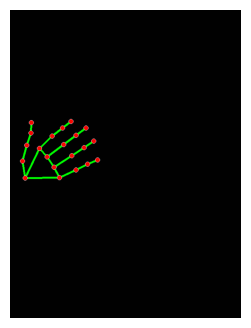

In [19]:
train_data = read_train()


height = 800
width = 600

sequence_id = 1000106739
data = read_landmark_data_by_id(sequence_id, train_data)

frame_id = data['frame'][0]

_, ax = plt.subplots(1, 1, figsize=(4, 4))
image = draw_right_hand(data, image=create_blank_image(height, width), frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')

plt.show()

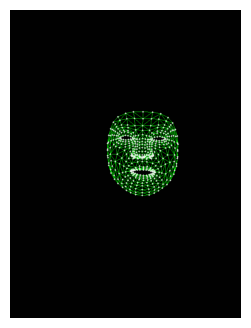

In [20]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
image = draw_face(data, image=create_blank_image(height, width), frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')

plt.show()

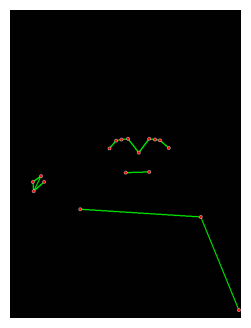

In [21]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
image = draw_pose(data, image=create_blank_image(height, width), frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')

plt.show()

<ipython-input-22-5c904b6d694d>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frame_id = data['frame'][0]


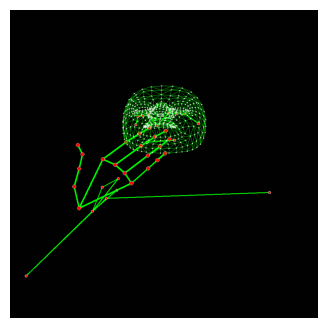

In [22]:
train_data = read_train()

def read_landmark_data_by_sign(sign_string, train_data):
    """Reads the landmark data by the given sequence id."""
    file_path = train_data[train_data['sign'] == sign_string].iloc[0]['path']
    return read_landmark_data_by_path(file_path)

height = 800
width = 600


data = read_landmark_data_by_sign("thankyou", train_data)
frame_id = data['frame'][0]

_, ax = plt.subplots(1, 1, figsize=(4, 4))

image = create_frame(data, frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')
plt.savefig('/kaggle/working/thankyou_plot.png', dpi=300)
plt.show()


In [23]:
def create_frames(sequence_id, train_data, height=800, width=800):
    data = read_landmark_data_by_id(sequence_id, train_data)
    frame_ids = data['frame'].unique()
    images = [create_frame(data, frame_id=fid, height=height, width=width) for fid in frame_ids]
    return np.array(images)


def create_animation(images, fig, ax):
    ax.axis('off')
    
    ims = []
    for img in images:
        im = ax.imshow(img, animated=True)
        ims.append([im])
    
    func_animation = mpl.animation.ArtistAnimation(
        fig, 
        ims, 
        interval=100, 
        blit=True,
        repeat_delay=1000)

    return func_animation

def get_sign_by_id(sequence_id, train_data):
    return train_data.loc[sequence_id]['sign']

def play_animation(sequence_id, train_data, height, width, figsize=(4, 4)):
    frames = create_frames(sequence_id, train_data, height=height, width=width)
    sign = get_sign_by_id(sequence_id, train_data)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    anim = create_animation(frames, fig, ax)
    ax.set_title(f'Sign: {sign}')
    
    video = anim.to_html5_video()
    html = IPython.display.HTML(video)
    IPython.display.display(html)
    plt.close()



In [24]:
sequence_id = get_random_sequence_id(train_data)
play_animation(sequence_id, train_data, height=height, width=width)

In [25]:
data = train_data[train_data['sign'] == 'happy']
sequence_id = get_random_sequence_id(data)

play_animation(sequence_id, train_data, height=height, width=width)

In [26]:
data = train_data[train_data['sign'] == 'thankyou']
sequence_id = get_random_sequence_id(data)

play_animation(sequence_id, train_data, height=height, width=width)

# _, ax = plt.subplots(1, 1, figsize=(4, 4))
# image = create_frame(data, frame_id=frame_id)
 
# ax.imshow(image)
# ax.axis('off')

# plt.show()

In [27]:
def create_gif(sequence_id, train_data, height, width, figsize=(4, 4)):
    frames = create_frames(sequence_id, train_data, height=height, width=width)
    sign = get_sign_by_id(sequence_id, train_data)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    anim = create_animation(frames, fig, ax)
    # Save the animation as a GIF
    anim.save('sign.gif', writer='imagemagick')
    plt.close()
    

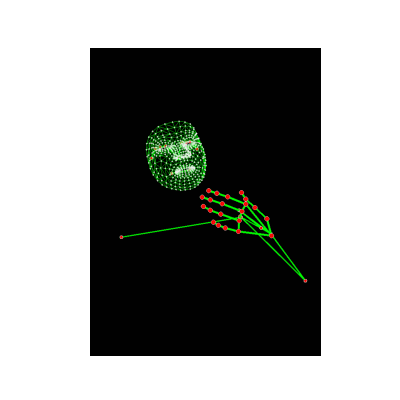

In [28]:
data = train_data[train_data['sign'] == 'thankyou']
sequence_id = get_random_sequence_id(data)

create_gif(sequence_id, train_data, height=height, width=width)
# Display the GIF
IPython.display.Image(filename='/kaggle/working/sign.gif')

In [29]:
def save_each_frame(sequence_id, train_data, height, width, figsize=(4, 4)):
    frames = create_frames(sequence_id, train_data, height=height, width=width)
    fig, ax = plt.subplots(figsize=figsize)
    for i, frame in enumerate(frames):
        ax.clear()  # Clear the previous frame
        ax.imshow(frame)
        ax.axis('off')  # Hide the axis
        plt.savefig(f'/kaggle/working/frame_{i:03d}.png')
    plt.close(fig)  # Close the figure after saving all frames

In [ ]:
# !rm /kaggle/working/frame_*
# !rm /kaggle/working/frames.zip
# # !rm /kaggle/working/kaggle_working_files.zip

In [ ]:
# data = train_data[train_data['sign'] == 'thankyou']
# sequence_id = get_random_sequence_id(data)
# save_each_frame(sequence_id, train_data, height=height, width=width)

In [ ]:
import os
import zipfile
import fnmatch

# Define the directory containing the frames
dir_to_zip = '/kaggle/working'

# Define the output ZIP file name
zip_file_path = '/kaggle/working/frames.zip'

# Create a ZIP file
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the directory
    for root, dirs, files in os.walk(dir_to_zip):
        for file in fnmatch.filter(files, 'frame_*.png'):
            # Create a relative path for files to keep the directory structure
            relative_path = os.path.relpath(os.path.join(root, file), os.path.join(dir_to_zip, '..'))
            zipf.write(os.path.join(root, file), relative_path)

print(f"Only 'frame_*.png' files in '{dir_to_zip}' are zipped into '{zip_file_path}'")


# Part 2: Feature Engineering and Model Training
This notebook's model is based on this one: https://www.kaggle.com/code/markwijkhuizen/gislr-tf-data-processing-transformer-training with edits:
 * Learn data preprocessing
 * Reproduce the results
 * twist the models and/or features

**Data Processing (from the original author's)**

Only lips, hands and arm pose coordinates are used.

A custom Tensorflow layer handles the data processing. In short, it filters all frames without coordinates for the hands and downsamples the input to 32 frames if it is too long.

**Model**

A transformer based model is used. The embedding layer makes an ambedding per landmark(lips/left hand/right hand/arm pose) and merges these embedding with fully connected layers. The transformer consists of just 2 blocks with a simple mean pooling and fully connected layers for classification.

# Plot Config

In [30]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

# Config

In [31]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = True

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
VERBOSE = 1 if IS_INTERACTIVE else 2

INPUT_SIZE = 64

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 100
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237

# Utils

In [32]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')

# Train

In [33]:
# Read Training Data
if IS_INTERACTIVE or not PREPROCESS_DATA:
    train = pd.read_csv('/kaggle/input/asl-signs/train.csv').sample(5000, random_state=SEED)
else:
    train = pd.read_csv('/kaggle/input/asl-signs/train.csv')

N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 5000


# Add File Path

In [34]:
# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-signs/{path}'

train['file_path'] = train['path'].apply(get_file_path)

# Ordinally Encode Sign

In [35]:
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [36]:
display(train.head())
display(train.info())

,path,participant_id,sequence_id,sign,file_path,sign_ord
56533,train_landmark_files/28656/3311214787.parquet,28656,3311214787,sticky,/kaggle/input/asl-signs/train_landmark_files/2...,206
63119,train_landmark_files/53618/3588192588.parquet,53618,3588192588,before,/kaggle/input/asl-signs/train_landmark_files/5...,20
8760,train_landmark_files/4718/1363575346.parquet,4718,1363575346,pretty,/kaggle/input/asl-signs/train_landmark_files/4...,178
93310,train_landmark_files/37779/951199059.parquet,37779,951199059,hen,/kaggle/input/asl-signs/train_landmark_files/3...,114
44842,train_landmark_files/36257/283190141.parquet,36257,283190141,tomorrow,/kaggle/input/asl-signs/train_landmark_files/3...,221


<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 56533 to 19516
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            5000 non-null   object
 1   participant_id  5000 non-null   int64 
 2   sequence_id     5000 non-null   int64 
 3   sign            5000 non-null   object
 4   file_path       5000 non-null   object
 5   sign_ord        5000 non-null   int16 
dtypes: int16(1), int64(2), object(3)
memory usage: 244.1+ KB


None

# Video Statistics

# Landmark Indices

In [37]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468

# 40 landmarks for lips
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])   
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)  # 21
RIGHT_HAND_IDXS0 = np.arange(522,543)  # 21
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0)) #  40+21+5 = 66 landmarks
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0)) #  40+21+5 = 66 landmarks
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)  # both hands 42 landmarks
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size

# Landmark indices in processed data
# index of lips landmarks in LEFT_DOMINANT0 0-39
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze() 

# index of left hand landmarks in LEFT_DOMINANT0 40-60
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()

# index of right hand landmarks in LEFT_DOMINANT0 empty []
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()

# index of both hands landmarks in LEFT_DOMINANT0 40-60 (actually only left hand)
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()

# index of left pose landmarks in LEFT_DOMINANT0 61-65
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66


In [38]:
# only left dominant landmarks used lips + left hand + left pose

LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


# Process Data Tensorflow

In [39]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [40]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
                    [0] * len(LIPS_IDXS) + [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                    # Z coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum
        
        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        
        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # Filter frames
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)
        
        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        if left_dominant:
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )
        
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

# Interpolate NaN Values

In [41]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544
        
"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    
    return data

# Create Dataset

In [42]:
# Get the full dataset
def preprocess_data():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        # Log message every 5000 samples
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        # Sanity check, data should not contain NaN values
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
    
    # Save Validation
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
    PARTICIPANT_IDS = train['participant_id'].values
    train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

    # Save Train
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)
    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save('X_val.npy', X_val)
    np.save('y_val.npy', y_val)
    np.save('NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)
    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')

In [43]:
# Preprocess All Data From Scratch
if PREPROCESS_DATA:
    preprocess_data()
    ROOT_DIR = '.'
else:
    ROOT_DIR = '/kaggle/input/gislr-dataset-public'
    
# Load Data
if USE_VAL:
    # Load Train
    X_train = np.load(f'{ROOT_DIR}/X_train.npy')
    y_train = np.load(f'{ROOT_DIR}/y_train.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
    # Load Val
    X_val = np.load(f'{ROOT_DIR}/X_val.npy')
    y_val = np.load(f'{ROOT_DIR}/y_val.npy')
    NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
    # Define validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)
else:
    X_train = np.load(f'{ROOT_DIR}/X.npy')
    y_train = np.load(f'{ROOT_DIR}/y.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS.npy')
    validation_data = None

# Train 
print_shape_dtype([X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN], ['X_train', 'y_train', 'NON_EMPTY_FRAME_IDXS_TRAIN'])
# Val
if USE_VAL:
    print_shape_dtype([X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL], ['X_val', 'y_val', 'NON_EMPTY_FRAME_IDXS_VAL'])
# Sanity Check
print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

X_train shape: (80229, 64, 66, 3), dtype: float32
y_train shape: (80229,), dtype: int32
NON_EMPTY_FRAME_IDXS_TRAIN shape: (80229, 64), dtype: float32
X_val shape: (14248, 64, 66, 3), dtype: float32
y_val shape: (14248,), dtype: int32
NON_EMPTY_FRAME_IDXS_VAL shape: (14248, 64), dtype: float32
# NaN Values X_train: 0


In [44]:
# Class Count
display(pd.Series(y_train).value_counts().to_frame('Class Count').iloc[[0,1,2,3,4, -5,-4,-3,-2,-1]])

,Class Count
135,358
136,352
194,351
60,351
67,348
170,277
249,267
56,266
21,263
231,255


# Number Of Frames

  0%|          | 0/64 [00:00<?, ?it/s]

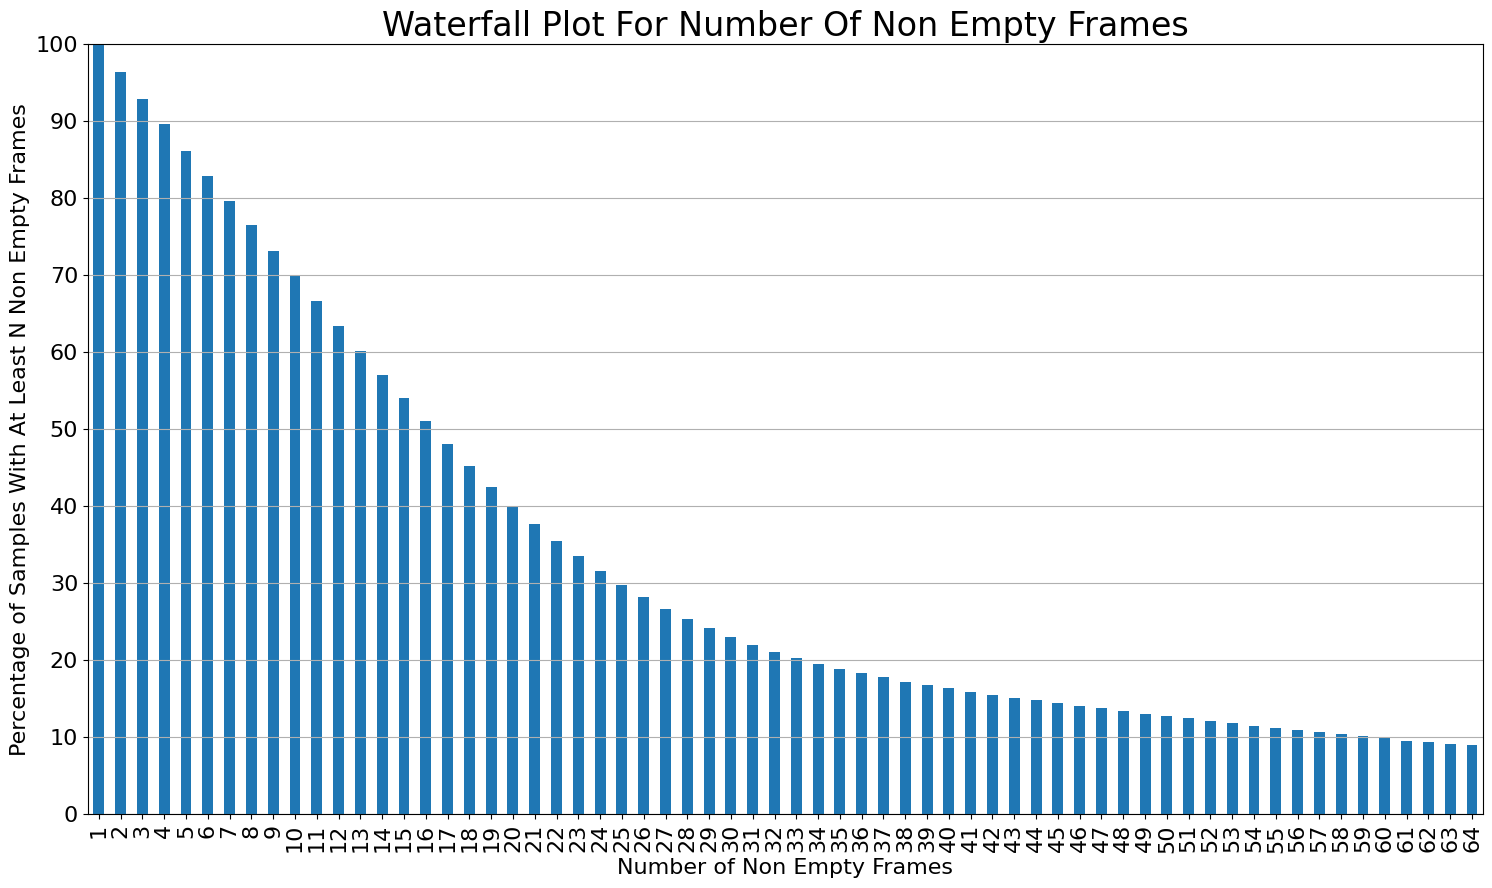

In [45]:
# Vast majority of samples fits has less than 32 non empty frames
N_EMPTY_FRAMES = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum(axis=1) 
N_EMPTY_FRAMES_WATERFALL = []
for n in tqdm(range(1,INPUT_SIZE+1)):
    N_EMPTY_FRAMES_WATERFALL.append(sum(N_EMPTY_FRAMES >= n) / len(NON_EMPTY_FRAME_IDXS_TRAIN) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Non Empty Frames')
pd.Series(N_EMPTY_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks(np.arange(INPUT_SIZE), np.arange(1, INPUT_SIZE+1))
plt.xlabel('Number of Non Empty Frames', size=16)
plt.yticks(np.arange(0, 100+10, 10))
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Non Empty Frames', size=16)
plt.show()

# Percentage of Frames Filled

In [46]:
# Percentage of frames filled, this is the maximum fill percentage of each landmark
P_DATA_FILLED = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum() / NON_EMPTY_FRAME_IDXS_TRAIN.size * 100
print(f'P_DATA_FILLED: {P_DATA_FILLED:.2f}%')

P_DATA_FILLED: 33.59%


# Feature Statistics - Lips

In [47]:
# Percentage of Lips Measurements
P_LEFT_LIPS_MEASUREMENTS = (X_train[:,:,LIPS_IDXS] != 0).sum() / X_train[:,:,LIPS_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_LIPS_MEASUREMENTS: {P_LEFT_LIPS_MEASUREMENTS:.2f}%')

P_LEFT_LIPS_MEASUREMENTS: 99.34%


  0%|          | 0/40 [00:00<?, ?it/s]

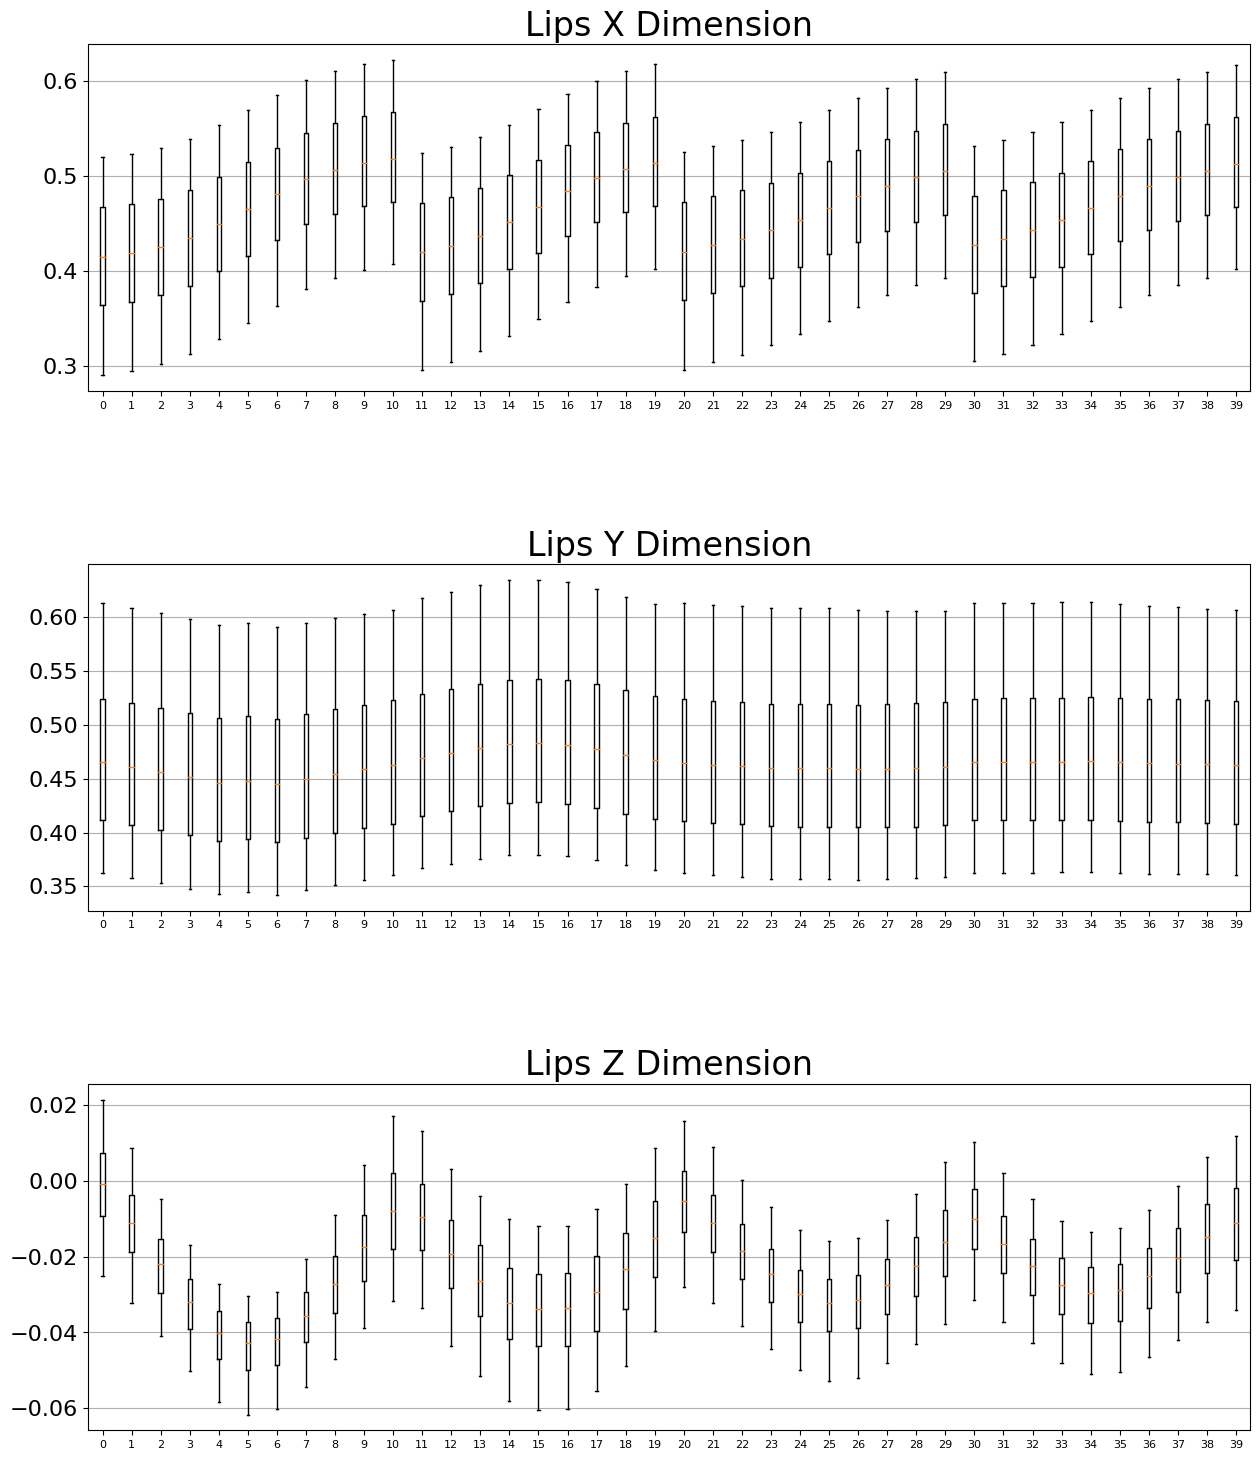

In [48]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T
    
    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

# Feature Statistics - Hands

In [49]:
# Verify Normalised to Left Hand Dominant
P_LEFT_HAND_MEASUREMENTS = (X_train[:,:,LEFT_HAND_IDXS] != 0).sum() / X_train[:,:,LEFT_HAND_IDXS].size / P_DATA_FILLED * 1e4
# P_RIGHT_HAND_MEASUREMENTS = (X_train[:,:,RIGHT_HAND_IDXS] != 0).sum() / X_train[:,:,RIGHT_HAND_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_HAND_MEASUREMENTS: {P_LEFT_HAND_MEASUREMENTS:.2f}%')

P_LEFT_HAND_MEASUREMENTS: 100.00%


  0%|          | 0/21 [00:00<?, ?it/s]

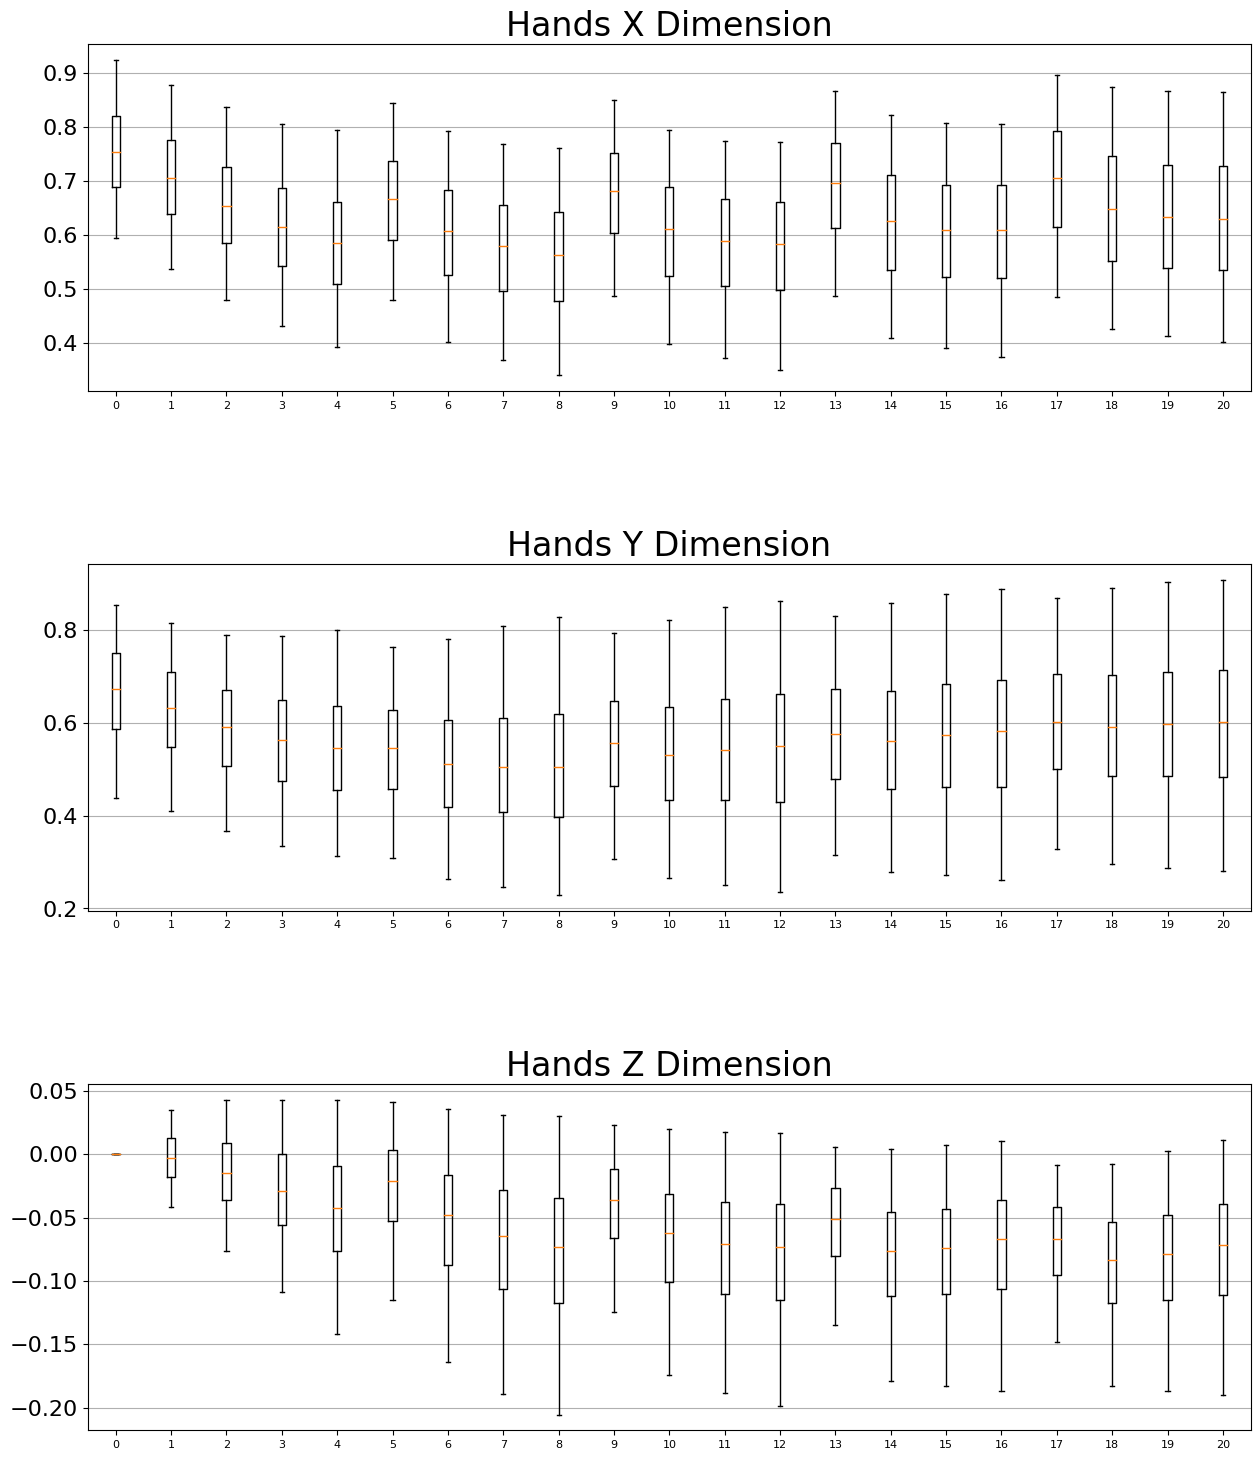

In [50]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
    
    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

# Feature Statistics - Pose

In [62]:
# Percentage of Lips Measurements
P_POSE_MEASUREMENTS = (X_train[:,:,POSE_IDXS] != 0).sum() / X_train[:,:,POSE_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_POSE_MEASUREMENTS: {P_POSE_MEASUREMENTS:.2f}%')

P_POSE_MEASUREMENTS: 100.00%


  0%|          | 0/5 [00:00<?, ?it/s]

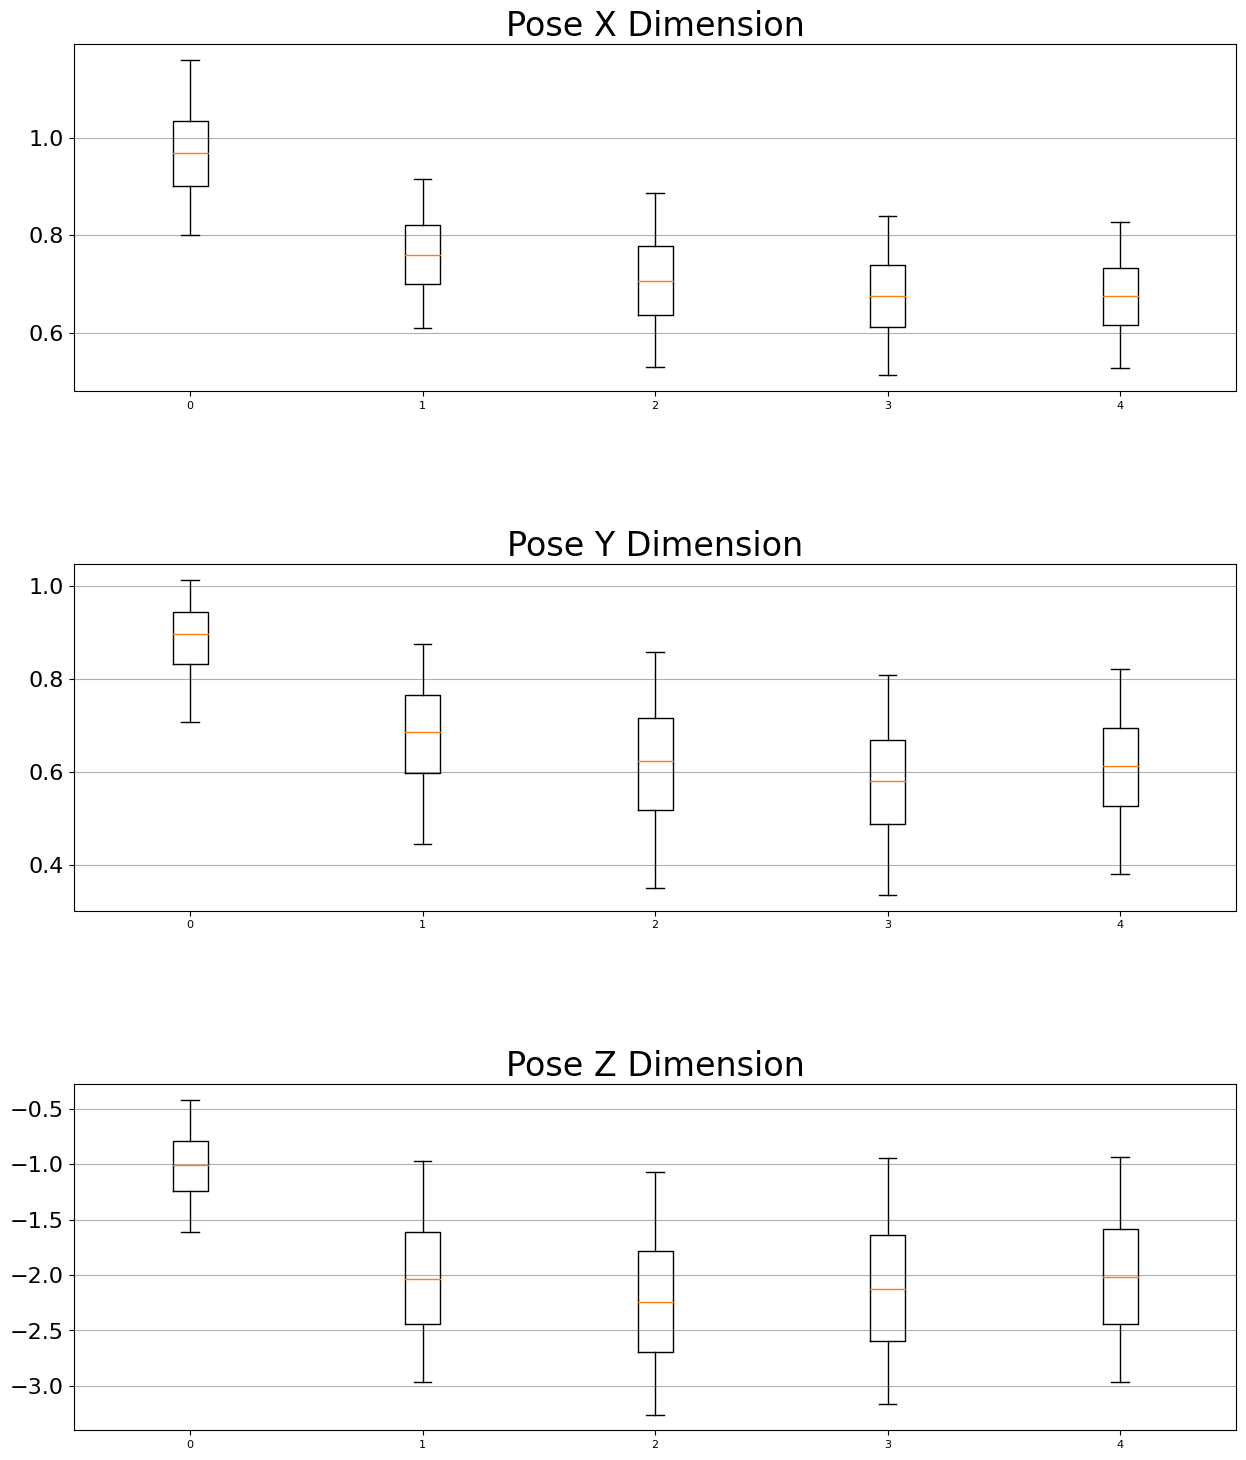

In [61]:
def get_pose_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T
    
    return POSE_MEAN, POSE_STD

POSE_MEAN, POSE_STD = get_pose_mean_std()

# Samples

In [67]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [68]:
dummy_dataset = get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN)
X_batch, y_batch = next(dummy_dataset)

for k, v in X_batch.items():
    print(f'{k} shape: {v.shape}, dtype: {v.dtype}')

# Batch shape/dtype
print(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
# Verify each batch contains each sign exactly N times
display(pd.Series(y_batch).value_counts().to_frame('Counts'))

frames shape: (1000, 64, 66, 3), dtype: float32
non_empty_frame_idxs shape: (1000, 64), dtype: float32
y_batch shape: (1000,), dtype: int64


,Counts
249,4
0,4
234,4
235,4
236,4
...,...
5,4
6,4
7,4
8,4


# Model Config

In [51]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

print(f'UNITS: {UNITS}')

UNITS: 512


# Transformer

Need to implement transformer from scratch as TFLite does not support the native TF implementation of MultiHeadAttention.

In [52]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [53]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)
    
        return x

# Landmark Embedding

In [54]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

# Embedding

In [55]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            lips_embedding, left_hand_embedding, pose_embedding,
        ), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

# Augmentation

In [56]:
# Not used, adds random X/y translation to input on samples level
class Augmentation(tf.keras.layers.Layer):
    def __init__(self, noise_std):
        super(Augmentation, self).__init__()
        self.noise_std = noise_std
    
    def add_noise(self, t):
        B = tf.shape(t)[0]
        return tf.where(
            t == 0.0,
            0.0,
            t + tf.random.normal([B,1,1,tf.shape(t)[3]], 0, self.noise_std),
        )
    
    def call(self, lips0, left_hand0, pose0, training=False):
        if training:
            # Lips
            lips0 = self.add_noise(lips0)
            # Left Hand
            left_hand0 = self.add_noise(left_hand0)
            # Pose
            pose0 = self.add_noise(pose0)
        
        return lips0, left_hand0, pose0

# Sparse Categorical Crossentropy With Label Smoothing

In [57]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

# Model

In [58]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )
    
    
    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )
    
    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])
        
    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)
    
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [63]:
tf.keras.backend.clear_session()

model = get_model()

In [64]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']            

In [ ]:
# takes a long time
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

# No NaN Predictions

In [69]:
if not PREPROCESS_DATA and TRAIN_MODEL:
    y_pred = model.predict_on_batch(X_batch).flatten()

    print(f'# NaN Values In Prediction: {np.isnan(y_pred).sum()}')

# NaN Values In Prediction: 0


# Weight Initialization

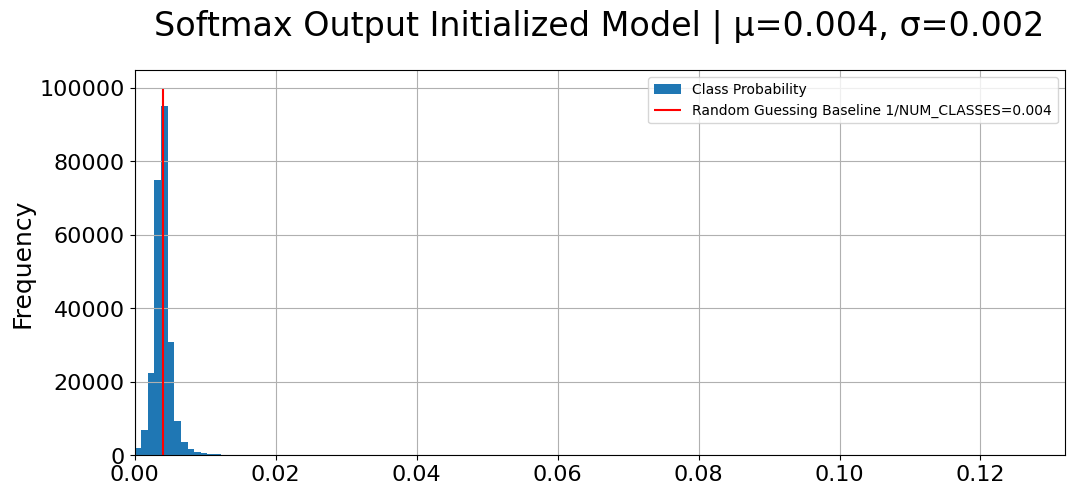

In [70]:
if not PREPROCESS_DATA and TRAIN_MODEL:
    plt.figure(figsize=(12,5))
    plt.title(f'Softmax Output Initialized Model | µ={y_pred.mean():.3f}, σ={y_pred.std():.3f}', pad=25)
    pd.Series(y_pred).plot(kind='hist', bins=128, label='Class Probability')
    plt.xlim(0, max(y_pred) * 1.1)
    plt.vlines([1 / NUM_CLASSES], 0, plt.ylim()[1], color='red', label=f'Random Guessing Baseline 1/NUM_CLASSES={1 / NUM_CLASSES:.3f}')
    plt.grid()
    plt.legend()
    plt.show()

# Learning Rate Scheduler

In [71]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [ ]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

# Weight Decay Callback

In [73]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Performance Benchmark

In [ ]:
# %%timeit -n 100
# if TRAIN_MODEL:
#     # Verify model prediction is <<<100ms
#     model.predict_on_batch({ 'frames': X_train[:1], 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TRAIN[:1] })
#     pass

# Training

In [74]:
if USE_VAL:
    # Verify Validation Dataset Covers All Signs
    print(f'# Unique Signs in Validation Set: {pd.Series(y_val).nunique()}')
    # Value Counts
    display(pd.Series(y_val).value_counts().to_frame('Count').iloc[[1,2,3,-3,-2,-1]])

# Unique Signs in Validation Set: 250


,Count
38,67
235,66
172,66
61,43
170,35
249,32


# Evaluate Initialzied Model

In [75]:
# Sanity Check
if TRAIN_MODEL and USE_VAL:
    _ = model.evaluate(*validation_data, verbose=2)

446/446 - 64s - loss: 5.5412 - acc: 0.0047 - top_5_acc: 0.0203 - top_10_acc: 0.0359 - 64s/epoch - 143ms/step


# Train

In [ ]:
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get new fresh model
    model = get_model()
    
    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
            steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
            epochs=N_EPOCHS,
            # Only used for validation data since training data is a generator
            batch_size=BATCH_SIZE,
            validation_data=validation_data,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose = VERBOSE,
        )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']            

In [ ]:
# Save Model Weights
model.save_weights('model.h5')

In [ ]:
if USE_VAL:
    # Validation Predictions
    y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
    # Label
    labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

# Landmark Attention Weights

In [ ]:
# Landmark Weights
for w in model.get_layer('embedding').weights:
    if 'landmark_weights' in w.name:
        weights = scipy.special.softmax(w)

landmarks = ['lips_embedding', 'left_hand_embedding', 'pose_embedding']

for w, lm in zip(weights, landmarks):
    print(f'{lm} weight: {(w*100):.1f}%')

# Classification Report

In [ ]:
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_val,
            y_val_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
        classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)

In [ ]:
if USE_VAL:
    print_classification_report()

# Training History

In [ ]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Submission

Submission code loosley based on [this notebook](https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#baseline) by [Darien Schettler
](https://www.kaggle.com/dschettler8845)

In [ ]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Preprocess Data
        x, non_empty_frame_idxs = self.preprocess_layer(inputs)
        # Add Batch Dimension
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        # Make Prediction
        outputs = self.model({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
        # Squeeze Output 1x250 -> 250
        outputs = tf.squeeze(outputs, axis=0)

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
demo_raw_data = load_relevant_data_subset(train['file_path'].values[5])
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)["outputs"]
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
demo_prediction = demo_output.numpy().argmax()
print(f'demo_prediction: {demo_prediction}, correct: {train.iloc[0]["sign_ord"]}')

In [ ]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Zip Model
!zip submission.zip /kaggle/working/model.tflite

In [ ]:
# Verify TFLite model can be loaded and used for prediction
# !pip install tflite-runtime
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/kaggle/working/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=demo_raw_data)
sign = output['outputs'].argmax()

print("PRED : ", ORD2SIGN.get(sign), f'[{sign}]')
print("TRUE : ", train.sign.values[0], f'[{train.sign_ord.values[0]}]')